## La Liga match outcome prediction (Win / Draw / Loss)

This notebook trains a **multiclass classification** model to predict the home team result:

- **Win** (home team wins)
- **Draw**
- **Loss** (home team loses)

### Inputs
- `homeTeam_name`
- `awayTeam_name`

### Target
- `match_outcome` from [`cleared_data/ml_dataset.csv`](../cleared_data/ml_dataset.csv)
  - `0 = Loss` (away team wins)
  - `1 = Draw`
  - `2 = Win` (home team wins)

### Model choice (why this model fits the problem)
We use **multinomial logistic regression (softmax)** on one-hot encoded team names.

- Team names are **categorical identifiers**; one-hot encoding makes them usable as model inputs.
- Logistic regression is a strong baseline for this setup: it’s fast, stable, and interpretable.
- The model outputs **probabilities** for each class (Win/Draw/Loss), not just a single label.


## 1) Imports and plotting configuration

We import the libraries used for:
- data handling (`pandas`, `numpy`)
- modeling (`scikit-learn`)
- plotting (`matplotlib`, `seaborn`)

We also set a consistent plotting theme and a fixed random seed for reproducibility.


In [2]:
!pip install pandas numpy scikit-learn matplotlib seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 18.4 MB/s  0:00:00 eta 0:00:01
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 32.7 MB/s  0:00:00m0:00:0100:01
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [seaborn]m4/5 [seaborn]earn]


In [3]:
from __future__ import annotations

import os
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
)
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

# If your environment cannot write to the default matplotlib cache path,
# this keeps matplotlib fast and avoids noisy warnings.
os.environ.setdefault("MPLCONFIGDIR", str(Path.cwd() / ".mplconfig"))
Path(os.environ["MPLCONFIGDIR"]).mkdir(parents=True, exist_ok=True)

RANDOM_STATE = 42

sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams["figure.dpi"] = 120


## 2) Load the dataset and keep only the required inputs

We load `cleared_data/ml_dataset.csv` and keep only:
- `homeTeam_name`
- `awayTeam_name`
- `matchday` (used only to create a time-aware split)
- `match_outcome` (the label)

This matches the requirement: **inputs are home/away team only**.


In [4]:
DATA_PATH = Path("..") / "cleared_data" / "ml_dataset.csv"

df_raw = pd.read_csv(DATA_PATH)

cols = ["homeTeam_name", "awayTeam_name", "matchday", "match_outcome"]
df = df_raw[cols].copy()

# Basic cleanup
for c in ["homeTeam_name", "awayTeam_name"]:
    df[c] = df[c].astype(str).str.strip()

df = df.dropna(subset=["homeTeam_name", "awayTeam_name", "matchday", "match_outcome"]).copy()

df["matchday"] = df["matchday"].astype(int)
df["match_outcome"] = df["match_outcome"].astype(int)

df.head(), df.shape

(             homeTeam_name             awayTeam_name  matchday  match_outcome
 0               UD Almería  Rayo Vallecano de Madrid         1              0
 1               Sevilla FC               Valencia CF         1              0
 2  Real Sociedad de Fútbol                 Girona FC         1              1
 3            UD Las Palmas              RCD Mallorca         1              1
 4            Athletic Club            Real Madrid CF         1              0,
 (1140, 4))

### Results & interpretation

- The printed shape tells you how many matches are available after keeping only the required columns.
- If any rows were dropped, it’s because a required field was missing.


## 3) Map the target to human-readable labels

The dataset uses numeric codes for the home team outcome:
- `0` = home **Loss**
- `1` = **Draw**
- `2` = home **Win**

We create a label column to make plots and reports easier to read.


In [5]:
OUTCOME_LABELS = {0: "Loss", 1: "Draw", 2: "Win"}

# Sanity check
unexpected = sorted(set(df["match_outcome"]) - set(OUTCOME_LABELS))
if unexpected:
    raise ValueError(f"Unexpected match_outcome values: {unexpected}")

df["outcome_label"] = df["match_outcome"].map(OUTCOME_LABELS)

(df["outcome_label"].value_counts(), df["outcome_label"].value_counts(normalize=True).round(3))

(outcome_label
 Draw    447
 Win     421
 Loss    272
 Name: count, dtype: int64,
 outcome_label
 Draw    0.392
 Win     0.369
 Loss    0.239
 Name: proportion, dtype: float64)

### Results & interpretation

- The output shows the **class counts** and **class proportions**.
- If the classes are imbalanced (common in football, especially for Draw), accuracy alone can be misleading.
  - That’s why we will also report **macro F1**, which gives each class equal importance.


## 4) Quick EDA: outcome distribution

Before training, we visualize the label distribution. This helps us:
- see whether the dataset is imbalanced
- justify metrics like **macro F1**


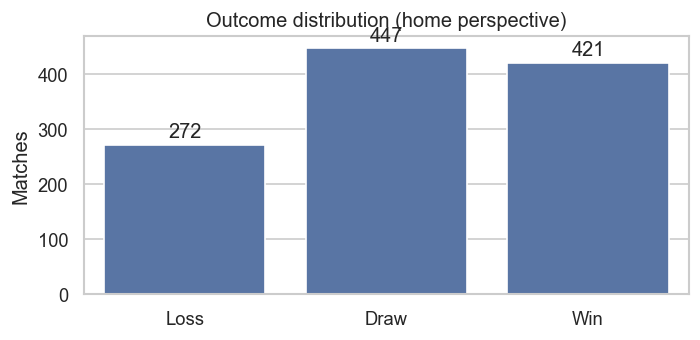

In [6]:
order = ["Loss", "Draw", "Win"]

plt.figure(figsize=(6, 3))
ax = sns.countplot(data=df, x="outcome_label", order=order)
ax.set_title("Outcome distribution (home perspective)")
ax.set_xlabel("")
ax.set_ylabel("Matches")
for container in ax.containers:
    ax.bar_label(container, padding=2)
plt.tight_layout()
plt.show()

### Results & interpretation

- If **Draw** is noticeably smaller than Win/Loss, the model will usually find Draw hardest to predict.
- In evaluation, pay attention to the Draw row/column in the confusion matrix and the Draw precision/recall.


## 5) Time-aware train/test split by matchday

Football seasons have a natural time order. To avoid training on matches that happen “after” the test matches, we:
- sort matchdays
- train on earlier matchdays
- test on later matchdays

This is closer to a real pre-match prediction scenario.


In [7]:
matchdays = np.array(sorted(df["matchday"].unique()))
if len(matchdays) < 5:
    raise ValueError("Not enough unique matchdays for time-aware splitting.")

# Use the last 20% of matchdays as test.
split_at = int(np.floor(0.8 * len(matchdays)))
train_days = set(matchdays[:split_at])
test_days = set(matchdays[split_at:])

train_df = df[df["matchday"].isin(train_days)].copy()
test_df = df[df["matchday"].isin(test_days)].copy()

X_train = train_df[["homeTeam_name", "awayTeam_name"]]
y_train = train_df["match_outcome"]

X_test = test_df[["homeTeam_name", "awayTeam_name"]]
y_test = test_df["match_outcome"]

{
    "n_matches_total": len(df),
    "n_train_matches": len(train_df),
    "n_test_matches": len(test_df),
    "train_matchday_range": (min(train_days), max(train_days)),
    "test_matchday_range": (min(test_days), max(test_days)),
}

{'n_matches_total': 1140,
 'n_train_matches': 900,
 'n_test_matches': 240,
 'train_matchday_range': (np.int64(1), np.int64(30)),
 'test_matchday_range': (np.int64(31), np.int64(38))}

### Results & interpretation

- The dictionary shows the matchday ranges used for training vs testing.
- If performance is lower than expected, this split is often the reason: predicting the future is harder than randomly mixing matches.


## 6) Model pipeline: One-hot team names → multinomial logistic regression

We build a single sklearn `Pipeline` that:
1) one-hot encodes `homeTeam_name` and `awayTeam_name`
2) trains a **multinomial** logistic regression classifier

Why this works well here:
- one-hot encoding creates “team-as-home” and “team-as-away” indicator features
- logistic regression learns weights for those features and uses a softmax to output class probabilities


In [8]:
categorical_features = ["homeTeam_name", "awayTeam_name"]

preprocess = ColumnTransformer(
    transformers=[
        (
            "teams",
            OneHotEncoder(handle_unknown="ignore"),
            categorical_features,
        )
    ],
    remainder="drop",
)

# solver='saga' works well with sparse one-hot features.
# Note: in scikit-learn >=1.5, setting `multi_class` is deprecated; the model uses multinomial by default.
base_model = LogisticRegression(
    solver="saga",
    penalty="l2",
    C=1.0,
    max_iter=5000,
    n_jobs=-1,
    random_state=RANDOM_STATE,
)

pipeline = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", base_model),
    ]
)

pipeline

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('teams', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse 

### Results & interpretation

- This pipeline ensures preprocessing is learned only from training data.
- `handle_unknown="ignore"` is important: it prevents errors if a team appears in the test set but wasn’t seen in training.


## 7) Hyperparameter tuning: regularization strength (C)

Logistic regression uses L2 regularization by default.
- `C` controls how strong regularization is:
  - smaller `C` → stronger regularization (simpler model)
  - larger `C` → weaker regularization (more flexible model)

We tune `C` using a **time-aware cross-validation** split based on matchday.


In [12]:
def make_matchday_time_cv_splits(df_subset: pd.DataFrame, n_splits: int = 5):
    """Create (train_idx, val_idx) splits where validation matchdays occur after training matchdays.

    Important: scikit-learn expects CV indices to be *positional* indices 0..N-1.
    When X is a pandas DataFrame, it uses pandas `.take()` under the hood, which is positional.
    """
    unique_days = np.array(sorted(df_subset["matchday"].unique()))
    if len(unique_days) < (n_splits + 1):
        n_splits = max(2, min(3, len(unique_days) - 1))

    # Split on matchday level (not individual rows)
    # We create increasing training windows with a forward validation block.
    day_splits = np.array_split(unique_days, n_splits + 1)

    splits = []
    matchday_arr = df_subset["matchday"].to_numpy()

    for i in range(1, len(day_splits)):
        train_days = np.concatenate(day_splits[:i])
        val_days = day_splits[i]

        # Use positional indices (0..len(df_subset)-1)
        train_idx = np.flatnonzero(np.isin(matchday_arr, train_days))
        val_idx = np.flatnonzero(np.isin(matchday_arr, val_days))

        if len(train_idx) == 0 or len(val_idx) == 0:
            continue
        splits.append((train_idx, val_idx))

    return splits

cv_splits = make_matchday_time_cv_splits(train_df, n_splits=5)
len(cv_splits), [(len(tr), len(va)) for tr, va in cv_splits]

(5, [(150, 150), (300, 150), (450, 150), (600, 150), (750, 150)])

In [13]:
Cs = [0.01, 0.1, 1.0, 3.0, 10.0, 30.0]

rows = []
for C in Cs:
    model = LogisticRegression(
        solver="saga",
        penalty="l2",
        C=C,
        max_iter=5000,
        n_jobs=-1,
        random_state=RANDOM_STATE,
    )
    pipe = Pipeline(steps=[("preprocess", preprocess), ("model", model)])

    scores = cross_validate(
        pipe,
        X_train,
        y_train,
        cv=cv_splits,
        scoring={"acc": "accuracy", "f1_macro": "f1_macro"},
        n_jobs=-1,
        error_score="raise",
    )

    rows.append(
        {
            "C": C,
            "cv_acc_mean": float(np.mean(scores["test_acc"])),
            "cv_acc_std": float(np.std(scores["test_acc"])),
            "cv_f1_macro_mean": float(np.mean(scores["test_f1_macro"])),
            "cv_f1_macro_std": float(np.std(scores["test_f1_macro"])),
        }
    )

tuning_df = pd.DataFrame(rows).sort_values("cv_f1_macro_mean", ascending=False)
tuning_df

/Users/mihaicoretchi/repos/AIA/.venv/lib/python3.14/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/mihaicoretchi/repos/AIA/.venv/lib/python3.14/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)
/Users/mihaicoretchi/repos/AIA/.venv/lib/python3.14/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_r

,C,cv_acc_mean,cv_acc_std,cv_f1_macro_mean,cv_f1_macro_std
5,30.00,0.449333,0.058057,0.434263,0.048383
4,10.00,0.446667,0.058576,0.430502,0.049543
3,3.00,0.448000,0.058332,0.430481,0.047873
2,1.00,0.452000,0.061449,0.429416,0.047558
1,0.10,0.412000,0.047027,0.315660,0.036140
0,0.01,0.370667,0.083544,0.181037,0.028331


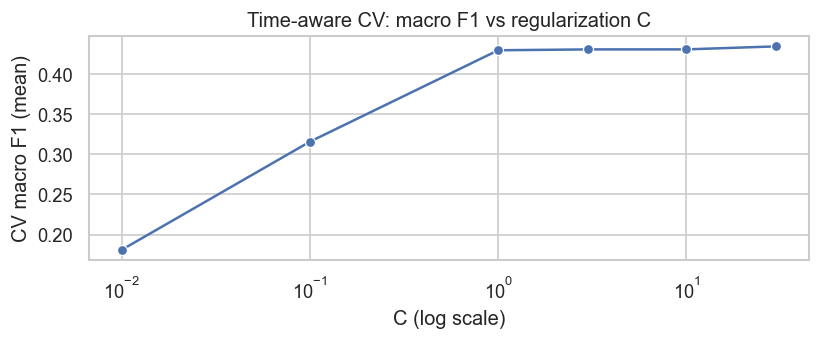

{'C': 30.0,
 'cv_acc_mean': 0.4493333333333333,
 'cv_acc_std': 0.058057442818872644,
 'cv_f1_macro_mean': 0.43426300413854957,
 'cv_f1_macro_std': 0.048383289358208646}

In [14]:
best_row = tuning_df.iloc[0].to_dict()
best_C = float(best_row["C"])

plt.figure(figsize=(7, 3))
ax = sns.lineplot(data=tuning_df.sort_values("C"), x="C", y="cv_f1_macro_mean", marker="o")
ax.set_xscale("log")
ax.set_title("Time-aware CV: macro F1 vs regularization C")
ax.set_xlabel("C (log scale)")
ax.set_ylabel("CV macro F1 (mean)")
plt.tight_layout()
plt.show()

best_row

### Results & interpretation

- The table and plot show how performance changes with `C`.
- We select the `C` that gives the best **mean CV macro F1**, because it balances performance across Win/Draw/Loss.


## 8) Fit the final model and evaluate on the held-out test matchdays

Now we train the pipeline on the full training set (earlier matchdays) and evaluate on the test set (later matchdays).

We report:
- **Accuracy**
- **Macro F1**
- **Confusion matrix** (raw counts + normalized)
- **Per-class precision/recall/F1** (classification report)


/Users/mihaicoretchi/repos/AIA/.venv/lib/python3.14/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/mihaicoretchi/repos/AIA/.venv/lib/python3.14/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


Test accuracy:  0.525
Test macro F1:  0.513

Classification report:

              precision    recall  f1-score   support

        Loss       0.46      0.42      0.44        55
        Draw       0.59      0.50      0.55       113
         Win       0.49      0.64      0.55        72

    accuracy                           0.53       240
   macro avg       0.51      0.52      0.51       240
weighted avg       0.53      0.53      0.52       240



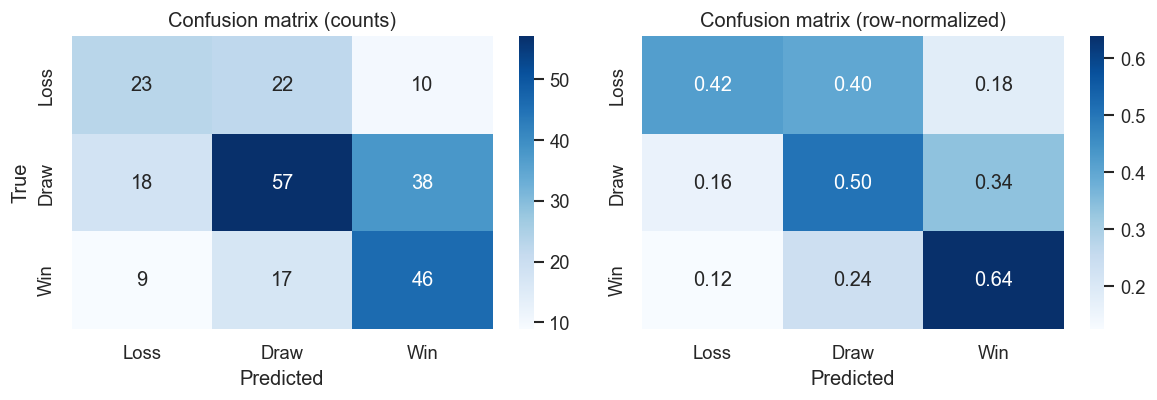

In [15]:
final_model = LogisticRegression(
    solver="saga",
    penalty="l2",
    C=best_C,
    max_iter=5000,
    n_jobs=-1,
    random_state=RANDOM_STATE,
)

final_pipeline = Pipeline(steps=[("preprocess", preprocess), ("model", final_model)])
final_pipeline.fit(X_train, y_train)

y_pred = final_pipeline.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1m = f1_score(y_test, y_pred, average="macro")

print(f"Test accuracy:  {acc:.3f}")
print(f"Test macro F1:  {f1m:.3f}")
print("\nClassification report:\n")
print(classification_report(y_test, y_pred, target_names=[OUTCOME_LABELS[i] for i in [0, 1, 2]]))

cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
cm_norm = cm / cm.sum(axis=1, keepdims=True)

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=[OUTCOME_LABELS[i] for i in [0, 1, 2]],
    yticklabels=[OUTCOME_LABELS[i] for i in [0, 1, 2]],
    ax=axes[0],
)
axes[0].set_title("Confusion matrix (counts)")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=[OUTCOME_LABELS[i] for i in [0, 1, 2]],
    yticklabels=[OUTCOME_LABELS[i] for i in [0, 1, 2]],
    ax=axes[1],
)
axes[1].set_title("Confusion matrix (row-normalized)")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()

### Results & interpretation

- Use the **row-normalized** confusion matrix to see, for each true class, where predictions go.
- Typical pattern in football:
  - Win/Loss may be easier than Draw
  - Draws often get misclassified as narrow wins or losses

If Draw performance is poor, that’s expected with teams-only features (no form, injuries, odds, etc.).


## 9) Predicting a single fixture (helper function)

In practice, you want to input:
- home team name
- away team name

and get:
- predicted class (Win/Draw/Loss)
- predicted probabilities for each class


In [16]:
def predict_fixture(home_team: str, away_team: str, model: Pipeline = final_pipeline) -> pd.Series:
    X = pd.DataFrame({"homeTeam_name": [home_team], "awayTeam_name": [away_team]})
    probs = model.predict_proba(X)[0]
    pred_class = int(model.predict(X)[0])

    out = {
        "homeTeam": home_team,
        "awayTeam": away_team,
        "prediction": OUTCOME_LABELS[pred_class],
        **{f"p_{OUTCOME_LABELS[c]}": float(probs[i]) for i, c in enumerate(model.classes_)},
    }
    return pd.Series(out)

# Example fixtures pulled from the dataset (first 5 rows)
examples = df[["homeTeam_name", "awayTeam_name"]].head(5)

pd.DataFrame(
    [predict_fixture(r.homeTeam_name, r.awayTeam_name) for r in examples.itertuples(index=False)]
)

,homeTeam,awayTeam,prediction,p_Loss,p_Draw,p_Win
0,UD Almería,Rayo Vallecano de Madrid,Loss,0.536079,0.461070,0.002850
1,Sevilla FC,Valencia CF,Draw,0.189593,0.447683,0.362724
2,Real Sociedad de Fútbol,Girona FC,Loss,0.354308,0.307178,0.338514
3,UD Las Palmas,RCD Mallorca,Win,0.287294,0.354688,0.358017
4,Athletic Club,Real Madrid CF,Draw,0.366590,0.429580,0.203829


### Results & interpretation

- The model returns a probability for each class.
- When probabilities are close (e.g., 0.35/0.33/0.32), the model is **uncertain** — that’s normal with teams-only information.


## 10) Explaining the model: inspecting coefficients

One benefit of logistic regression is interpretability.

Because we one-hot encode team names, the model learns weights for features like:
- `homeTeam_name = Real Madrid CF`
- `awayTeam_name = Real Madrid CF`

For each class (Loss/Draw/Win), the model has a set of coefficients:
- positive coefficient → pushes probability **toward** that class
- negative coefficient → pushes probability **away** from that class

Important: coefficients show **associations in this dataset**, not causal effects.


In [17]:
# Extract feature names from the one-hot encoder
encoder: OneHotEncoder = final_pipeline.named_steps["preprocess"].named_transformers_["teams"]
feature_names = encoder.get_feature_names_out(["homeTeam_name", "awayTeam_name"])

coef = final_pipeline.named_steps["model"].coef_  # shape: (n_classes, n_features)
classes = final_pipeline.named_steps["model"].classes_  # should be [0,1,2]

coef_df = pd.DataFrame(coef.T, index=feature_names, columns=[OUTCOME_LABELS[int(c)] for c in classes])
coef_df.head()

,Loss,Draw,Win
homeTeam_name_Athletic Club,-0.835414,-0.118028,0.953442
homeTeam_name_CA Osasuna,-0.251539,-0.133469,0.385008
homeTeam_name_CD Leganés,0.430908,-0.735755,0.304847
homeTeam_name_Club Atlético de Madrid,-1.712581,0.083670,1.628911
homeTeam_name_Cádiz CF,-0.065550,0.192588,-0.127037


In [18]:
def top_coefficients_for_class(coef_df: pd.DataFrame, class_name: str, k: int = 12) -> pd.DataFrame:
    s = coef_df[class_name].sort_values(ascending=False)
    top_pos = s.head(k)
    top_neg = s.tail(k)
    return pd.concat([top_pos, top_neg]).to_frame(name="coef")

for class_name in ["Loss", "Draw", "Win"]:
    display(top_coefficients_for_class(coef_df, class_name, k=10))

,coef
homeTeam_name_UD Almería,1.769525
awayTeam_name_FC Barcelona,1.481583
awayTeam_name_Real Madrid CF,1.217870
homeTeam_name_Levante UD,1.106111
awayTeam_name_Villarreal CF,0.807274
homeTeam_name_Real Valladolid CF,0.615351
homeTeam_name_Granada CF,0.612673
awayTeam_name_Club Atlético de Madrid,0.551589
awayTeam_name_Real Sociedad de Fútbol,0.433189
homeTeam_name_CD Leganés,0.430908


,coef
awayTeam_name_Elche CF,1.676760
homeTeam_name_Levante UD,1.461075
homeTeam_name_UD Almería,1.418850
awayTeam_name_Cádiz CF,1.101337
homeTeam_name_Real Oviedo,0.759619
homeTeam_name_Elche CF,0.618470
awayTeam_name_Real Oviedo,0.575334
awayTeam_name_CD Leganés,0.546173
homeTeam_name_Rayo Vallecano de Madrid,0.404520
awayTeam_name_Real Betis Balompié,0.277467


,coef
awayTeam_name_Granada CF,2.459223
awayTeam_name_Real Valladolid CF,2.313673
homeTeam_name_Club Atlético de Madrid,1.628911
homeTeam_name_Real Madrid CF,1.546284
awayTeam_name_Cádiz CF,1.452641
homeTeam_name_FC Barcelona,1.231479
awayTeam_name_UD Almería,1.195596
homeTeam_name_Athletic Club,0.953442
homeTeam_name_Elche CF,0.801799
awayTeam_name_Elche CF,0.731958


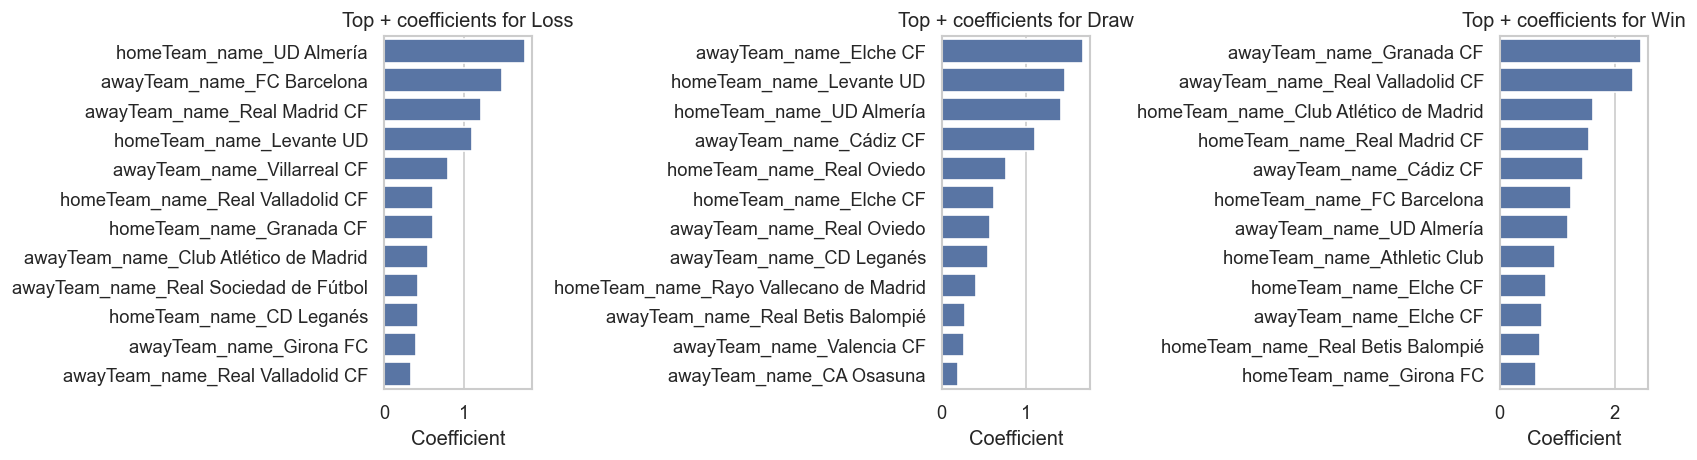

In [19]:
# Visualize the most positive coefficients per class (easy to discuss)

top_k = 12
fig, axes = plt.subplots(1, 3, figsize=(14, 4), sharey=False)

for ax, class_name in zip(axes, ["Loss", "Draw", "Win"]):
    s = coef_df[class_name].sort_values(ascending=False).head(top_k)
    plot_df = s.reset_index()
    plot_df.columns = ["feature", "coef"]

    sns.barplot(data=plot_df, x="coef", y="feature", ax=ax)
    ax.set_title(f"Top + coefficients for {class_name}")
    ax.set_xlabel("Coefficient")
    ax.set_ylabel("")

plt.tight_layout()
plt.show()

### Results & interpretation

- Features like `homeTeam_name=...` with large positive weight for **Win** mean: *when this team is the home team, the model leans more toward Win*.
- Features like `awayTeam_name=...` with large positive weight for **Loss** mean: *when this team is the away team, the model leans more toward home Loss*.

This matches football intuition: stronger teams tend to push predictions toward Win when at home, and toward Loss when visiting.


## Summary / takeaways

- With **only team names** as inputs, the model learns team-specific tendencies (home vs away effects).
- Expect limited performance ceiling: many factors that drive football outcomes (form, injuries, red cards, odds, etc.) are not included.
- Still, this provides a clean, interpretable baseline for a 3-class prediction problem.


In [26]:
def resolve_team_name(query: str, known_teams: list[str]) -> str:
    q = query.strip().lower()

    # 1) exact match ignoring case
    for t in known_teams:
        if t.lower() == q:
            return t

    # 2) substring match (e.g., "barcelona" -> "FC Barcelona")
    candidates = [t for t in known_teams if q in t.lower()]
    if len(candidates) == 1:
        return candidates[0]

    # 3) fallback: show options
    raise ValueError(
        f"Could not uniquely resolve team name '{query}'. Matches: {candidates[:10]}"
    )

known_teams = sorted(set(df["homeTeam_name"]).union(set(df["awayTeam_name"])))

home = resolve_team_name("FC Barcelona", known_teams)
away = resolve_team_name("CA Osasuna", known_teams)

predict_fixture(home, away)

homeTeam      FC Barcelona
awayTeam        CA Osasuna
prediction             Win
p_Loss            0.069548
p_Draw            0.179589
p_Win             0.750863
dtype: object